In [1]:
using BenchmarkTools

In [2]:
#import Pkg; Pkg.add("CSV")
#Pkg.add("PyPlot")

In [3]:
using Plots

In [4]:
using CSV

In [5]:
""" Linear interpolation
"""
function build_interp1d(x, y)
    function interp1d_glob(t)
        idx = searchsortedfirst(x, t)
        if idx <= 1
            return y[1]
        elseif idx == length(x)+1
            return y[end]
        else
            prev = idx-1
            slope = (y[idx] - y[prev])/(x[idx] - x[prev])
            return y[prev] + slope*(t - x[prev])
        end
    end
    return interp1d_glob
end

build_interp1d

In [6]:
path = "../data/Fichiers_Meteo_RT2012/H1a_Trappes.csv"
data = CSV.read(path; header=1);

println(names(data))

Symbol[Symbol("# Htsmd"), :te0, :dirN]


In [7]:
seconds_values = Array(data[!, 1]) * 60.0*60.0;
Text_values = Array(data[!, 2]);
directSun_values = Array(data[!, 3]);

In [8]:
#x = 1.0*collect(1:10)
#y = rand(size(x)...);
#@btime fi($t)

In [9]:
T_ext = build_interp1d(seconds_values, Text_values)
solar_irrad = build_interp1d(seconds_values, directSun_values)

(::var"#interp1d_glob#3"{Array{Float64,1},Array{Float64,1}}) (generic function with 1 method)

In [10]:
include("SimuThermiqueSolver.jl")
using .SimuThermiqueSolver

In [11]:
pyplot()

Plots.PyPlotBackend()

In [12]:
min = 60.0
hour = 60.0 * min
day = 24 * hour

86400.0

In [28]:
m = Model(dt=10min)

clay = Material(1.28, 880.0, 1450.0) # Clay

w = add_wall!(m, "w", material=clay, thickness=.30, area=1.)

add_convectivesource!(m, w.ext, Tsource=T_ext,  hS=1.0)
add_convectivesource!(m, w.int, Tsource=t->0.0, hS=2.0)
add_directsource!(m, w.ext, flux=t->0.8*solar_irrad(t))

In [29]:
@btime init_solver($m);

  14.890 μs (128 allocations: 40.52 KiB)


In [30]:
state = init_solver(m);

# Burn (solve in reverse)
state.dt = -state.dt
state.t = 15day

save = [m.id_to_index[w.int], m.id_to_index[w.ext]];
n_iter = Int(floor(15day/m.dt));

sol = zeros(n_iter, length(save))
times = zeros(n_iter)
for k in 1:n_iter
    iter!(state)
    sol[k, :] = state.T[save]
    times[k] = state.t
end


# solve
state.dt = -state.dt
state.t = 20day

save = [m.id_to_index[w.int], m.id_to_index[w.ext]];
n_iter = Int(floor(20day/m.dt));

sol = zeros(n_iter, length(save))
times = zeros(n_iter)
for k in 1:n_iter
    iter!(state)
    sol[k, :] = state.T[save]
    times[k] = state.t
end


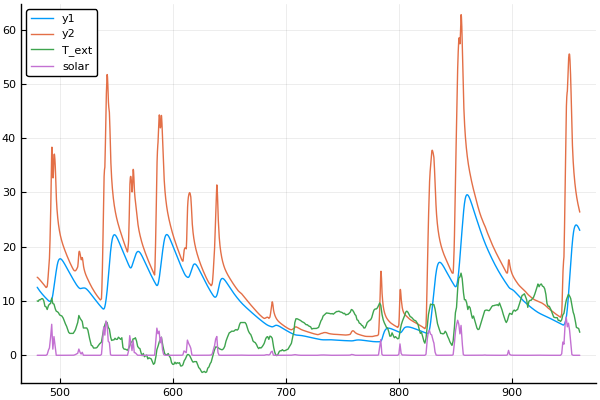

In [31]:
plot(times/hour, sol)
plot!(times/hour, [T_ext(t) for t in times], label="T_ext")
plot!(times/hour, [0.01*solar_irrad(t) for t in times], label="solar")

MetaModel

same as model but takes Params instead of values

